In [20]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import os
import numpy as np
import json
import requests
from config import weatherbit_key
from pprint import pprint
from retry_requests import retry
import requests_cache
import openmeteo_requests

In [24]:
with open('descriptions.json', 'r') as f:
    data = json.load(f)
# Accessing data
code = ['weather_code']

#data[code]['day']["description"]
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 39.0376,
	"longitude": -77.4158,
	"start_date": "2000-01-01",
	"end_date": "2008-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"],
	"daily": "weather_code",
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch",
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(7).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(10).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(11).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(12).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(14).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(15).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(16).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(17).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(18).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["weather_code"] = hourly_weather_code.astype(int)
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
#print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code

daily_dataframe = pd.DataFrame(data = daily_data)
#daily_dataframe.head()
hourly_dataframe.head()

Coordinates 39.05096435546875°N -77.40740966796875°E
Elevation 101.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


date  temperature_2m  relative_humidity_2m  \
0 2000-01-01 04:00:00+00:00       36.844700             84.508644   
1 2000-01-01 05:00:00+00:00       36.214699             84.774651   
2 2000-01-01 06:00:00+00:00       36.034698             84.456161   
3 2000-01-01 07:00:00+00:00       32.704700             90.322327   
4 2000-01-01 08:00:00+00:00       30.364700             93.612801   

   apparent_temperature  precipitation  rain  snowfall  snow_depth  \
0             31.711010            0.0   0.0       0.0         0.0   
1             30.907288            0.0   0.0       0.0         0.0   
2             30.554066            0.0   0.0       0.0         0.0   
3             26.706497            0.0   0.0       0.0         0.0   
4             24.137669            0.0   0.0       0.0         0.0   

   weather_code  pressure_msl  surface_pressure  cloud_cover  cloud_cover_low  \
0             0   1022.900024       1010.199524          0.0              0.0   
1             0   1022.799988       1010.084900          0.0              0.0   
2             0   1023.000000       1010.277649          0.0              0.0   
3             0   1022.700012       1009.896057          0.0              0.0   
4             0   1023.099976       1010.230469          0.0              0.0   

   cloud_cover_mid  cloud_cover_high  wind_speed_10m  wind_speed_100m  \
0              0.0               0.0        3.325540         4.161060   
1              0.0               0.0        3.537008         4.803042   
2              0.0               0.0        3.848680         6.085298   
3              0.0               0.0        4.501876         8.325127   
4              0.0               0.0        4.562603        10.997762   

   wind_direction_10m  wind_direction_100m  wind_gusts_10m  
0          250.346085           216.253922          3.8029  
1          251.564957           207.758453          3.8029  
2          234.462234           197.102814          4.6977  
3          206.564987           186.170074          6.9347  
4          191.309891           184.666779          7.3821

In [90]:
#clean_data = hourly_dataframe.rename(columns={'date': "Date", 'relative_humidity_2m':"Relative Humidity", 'apparent_temperature':"Temperature",'precipitation': "Precipitation",'rain':"Rain Fall",'snowfall': "Snow Fall",'snow_depth':"Amount of Snow",'weather_code':"Weather"})
#clean_data = clean_data[['Date','Temperature','Precipitation', 'Rain Fall', 'Snow Fall', 'Amount of Snow', 'Weather']]
#clean_data = pd.DataFrame(clean_data)


#def weather(code):
   # with open('descriptions.json', 'r') as f:
        #data = json.load(f)
    #code = f"{code}"
    #data=data[code]['day']["description"]
    #return data
#for code in clean_data['Weather']:
    #data = weather(code)
    #clean_data['Weather'] = clean_data['Weather'].replace(to_replace=code, value=data, regex=True)

#clean_data

In [178]:
airline_df = Path('airlines_2000_2008_iad_origin.csv')
weather_df = Path('weather_by_hour.csv')
airline_df = pd.read_csv(airline_df)
weather_df = pd.read_csv(weather_df)
weather_df

Unnamed: 0                       Date  Temperature  Precipitation  \
0               0  2000-01-01 04:00:00+00:00    31.711010            0.0   
1               1  2000-01-01 05:00:00+00:00    30.907288            0.0   
2               2  2000-01-01 06:00:00+00:00    30.554066            0.0   
3               3  2000-01-01 07:00:00+00:00    26.706497            0.0   
4               4  2000-01-01 08:00:00+00:00    24.137669            0.0   
...           ...                        ...          ...            ...   
78907       78907  2008-12-31 23:00:00+00:00    16.250614            0.0   
78908       78908  2009-01-01 00:00:00+00:00    14.915319            0.0   
78909       78909  2009-01-01 01:00:00+00:00    13.988867            0.0   
78910       78910  2009-01-01 02:00:00+00:00    13.298199            0.0   
78911       78911  2009-01-01 03:00:00+00:00    13.224157            0.0   

       Rain Fall  Snow Fall  Amount of Snow       Weather  
0            0.0        0.0             0.0         Sunny  
1            0.0        0.0             0.0         Sunny  
2            0.0        0.0             0.0         Sunny  
3            0.0        0.0             0.0         Sunny  
4            0.0        0.0             0.0         Sunny  
...          ...        ...             ...           ...  
78907        0.0        0.0             0.0         Sunny  
78908        0.0        0.0             0.0         Sunny  
78909        0.0        0.0             0.0        Cloudy  
78910        0.0        0.0             0.0        Cloudy  
78911        0.0        0.0             0.0  Mainly Sunny  

[78912 rows x 8 columns]

In [ ]:
conair_df = airline_df[["Month", "Year", 'DayofMonth']].astype(int)
dep_df = airline_df['DepTime'].round(-2)

dep_df = pd.DataFrame(dep_df)

conair_df['Departure'] = dep_df['DepTime']
conair_df = conair_df.fillna(0)
conair_df['Departure'] = conair_df["Departure"].astype(int)
#i = 0
for index, row in conair_df.iterrows():
 
    #i = i + 1
    month = row["Month"]
    day = row["DayofMonth"]
    year = row["Year"]
    time = row["Departure"]/100
    if month < 10:
        month = f'0{month}'
    if day < 10:
        day = f'0{day}'
    if time < 10:
        time = f'0{int(time)}'
    else:
        time = f'{int(time)}'
    #if i == 15:
        #break
    
    date = f'{year}-{month}-{day} {time}:00:00+00:00'
    for index, row in weather_df.iterrows():
        if date == row['Date']:
            weather = row['Weather']
            airline_df['Weather'] = weather_df['Weather']
            print(row['Weather'])
            break

airline_df.head()
airline_df.to_csv('complete.csv') 

In [ ]:
conair_df = airline_df[["Month", "Year", 'DayofMonth']].astype(int)
dep_df = airline_df['DepTime'].round(-2)

dep_df = pd.DataFrame(dep_df)

conair_df['Departure'] = dep_df['DepTime']
conair_df = conair_df.fillna(0)
conair_df['Departure'] = conair_df["Departure"].astype(int)
#i = 0
for index, row in conair_df.iterrows():
 
    #i = i + 1
    month = row["Month"]
    day = row["DayofMonth"]
    year = row["Year"]
    time = row["Departure"]/100
    if month < 10:
        month = f'0{month}'
    if day < 10:
        day = f'0{day}'
    if time < 10:
        time = f'0{int(time)}'
    else:
        time = f'{int(time)}'
    #if i == 15:
        #break
    
    date = f'{year}-{month}-{day} {time}:00:00+00:00'
    for index, row in weather_df.iterrows():
        if date == row['Date']:
            weather = row['Weather']
            airline_df['Weather'] = weather_df['Weather']
            print(row['Weather'])
            break

airline_df.head()
airline_df.to_csv('complete.csv') 

In [134]:
for index, row in date.iterrows():
    month = row["Month"]
    day = row["DayofMonth"]
    year = row["Year"]
    time = (row["Dep Time"]
    if month < 10:
        month = f'0{month}'
    if day < 10:
        day = f'0{day}'

    

2004-03-02
2004-09-09
2004-09-09
2004-09-09
2004-09-09
2004-09-09
2004-09-09
2004-09-08
2004-05-06
2004-05-06
2004-08-01
2004-08-01
2004-09-06
2004-09-06
2004-09-06
2004-09-06
2004-09-06
2004-09-06
2004-09-06
2004-09-06
2004-09-06
2004-08-08
2004-08-08
2004-08-08
2004-08-08
2004-04-09
2004-04-09
2004-04-09
2004-04-09
2004-07-07
2004-07-07
2004-07-07
2004-07-07
2004-07-07
2004-07-07
2004-07-06
2004-07-06
2004-07-06
2004-07-06
2004-07-06
2004-02-09
2004-04-06
2004-04-06
2004-07-02
2004-07-02
2004-07-02
2004-08-02
2004-08-02
2004-08-02
2004-08-02
2004-08-02
2004-08-02
2004-08-02
2004-08-02
2004-01-01
2004-01-01
2004-01-01
2004-01-01
2004-01-01
2004-02-03
2004-02-03
2004-08-08
2004-08-08
2004-04-07
2004-02-09
2004-02-09
2004-02-09
2004-02-09
2004-02-09
2004-01-04
2004-01-04
2004-01-04
2004-03-05
2004-03-05
2004-03-05
2004-03-05
2004-03-05
2004-08-07
2004-08-07
2004-08-07
2004-08-07
2004-08-07
2004-09-02
2004-09-02
2004-01-06
2004-09-07
2004-09-07
2004-09-07
2004-09-07
2004-08-04
2004-08-04

In [ ]:
day = f'2004-03-02 12:00:00+00:00'
wet = weather_df.loc[weather_df["Date"] == day]
wet

In [34]:
#creating a dataframe for each year.
year_2000 = df.loc[(df["Year"] == 2000)]
year_2001 = df.loc[(df["Year"] == 2001)]
year_2002 = df.loc[(df["Year"] == 2002)]
year_2003 = df.loc[(df["Year"] == 2003)]
year_2004 = df.loc[(df["Year"] == 2004)]
year_2005 = df.loc[(df["Year"] == 2005)]
year_2006 = df.loc[(df["Year"] == 2006)]
year_2007 = df.loc[(df["Year"] == 2007)]
year_2008 = df.loc[(df["Year"] == 2008)]



In [52]:
year_2004
date = year_2004[['Year', 'Month', 'DayofMonth']]
date = pd.DataFrame(date)
for index, row in date.iterrows():
    day = print(f'{row["Year"]}-{row["Month"]}-{row["DayofMonth"]}')
    for day in weather_df:
        

2004-3-2
2004-9-9
2004-6-13
2004-3-25
2004-7-18
2004-5-21
2004-10-21
2004-9-8
2004-5-6
2004-9-17
2004-8-1
2004-6-30
2004-9-6
2004-10-13
2004-9-12
2004-9-28
2004-3-30
2004-7-19
2004-4-14
2004-9-24
2004-9-6
2004-8-8
2004-12-28
2004-7-31
2004-10-24
2004-4-9
2004-10-31
2004-12-6
2004-6-13
2004-7-7
2004-12-31
2004-7-28
2004-9-18
2004-11-30
2004-11-18
2004-7-6
2004-9-12
2004-10-16
2004-11-16
2004-6-18
2004-2-9
2004-4-6
2004-12-19
2004-7-2
2004-5-14
2004-7-25
2004-8-2
2004-12-6
2004-11-27
2004-9-20
2004-12-28
2004-12-18
2004-12-26
2004-10-11
2004-1-1
2004-7-12
2004-12-17
2004-9-23
2004-11-8
2004-2-3
2004-9-19
2004-8-8
2004-9-26
2004-4-7
2004-2-9
2004-1-18
2004-1-30
2004-6-17
2004-4-10
2004-1-4
2004-10-28
2004-11-18
2004-3-5
2004-2-22
2004-6-12
2004-12-24
2004-8-20
2004-8-7
2004-9-21
2004-7-30
2004-11-16
2004-2-21
2004-9-2
2004-1-13
2004-1-6
2004-9-7
2004-7-19
2004-11-28
2004-8-12
2004-8-4
2004-10-18
2004-3-19
2004-1-12
2004-10-6
2004-1-2
2004-12-16
2004-7-4
2004-1-2
2004-9-19
2004-10-4
2004-4

In [ ]:
weather_df["Date"]

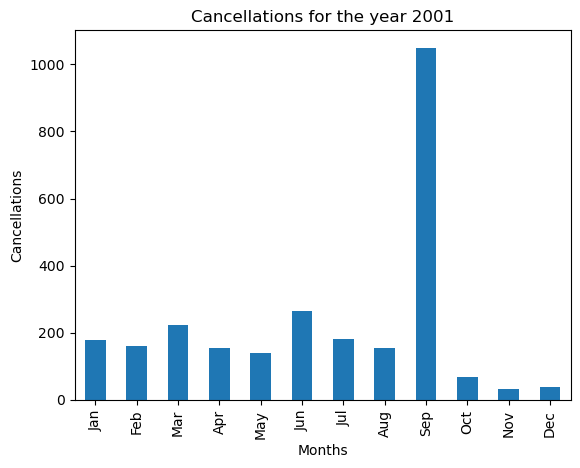

In [10]:
def cancel(years):
    year = years["Year"].max()
    x_can = years.loc[(years['Cancelled'] == 1)]
    y_mon = x_can.groupby(['Month'])['Cancelled'].value_counts()
    y_mon = pd.DataFrame(y_mon)
    
    y_mon.plot.bar(color='tab:blue', legend=False)
    plt.xlabel("Months")
    plt.ylabel("Cancellations")
    x_axis = np.arange(12)
    
    plt.title(f"Cancellations for the year {year}")
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.show()
    return

cancel(year_2001)